# Minipipe  + PyArrow Plasma

In this section we demonstrate how to use Pyarrow.plama with Minipipe to speed up pipelines with large data chunks. To follow this tutorial you'll need [Pyarrow](https://arrow.apache.org/docs/python/install.html) installed. Plasma allows Python processes to share data by sharing memory addresses rather than passing data between processes like Multiprocessing.Queue. This means for large data chunk sizes, 10MB or more, you can get significant speed-ups with Plasma.

## Long Pipelines

First let's look at a long sequential pipeline with multiple transform segments. Here we just want to measure the throughput so we'll make some dummy pipe segments that just passes data through.  

In [50]:
from minipipe import Source, Transform, Sink, Pipeline

@Source
def gen_data(data, n):
    for _ in range(n):
        yield data # same data each step
            
@Transform
def trans(data):
    return data

@Sink
def print_data(data):
    print(f'dtype:{type(data)} size:{data.nbytes/1e6:0.3f} Mb')

To build a pipeline that uses pyarrow.plasma all we need to do in set Pipeline.plasma = True. 

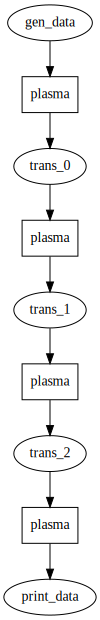

In [49]:
import numpy as np

data = np.random.randn(1250, 10000) # 100 mb of data

plsm_pipe = (Pipeline(plasma=True)
             .add(gen_data(data, n=10))
             .add(trans)
             .add(trans)
             .add(trans)
             .add(print_data)
             .build())

plsm_pipe.diagram(True)

In [3]:
plsm_pipe.run(timeit=True)

2020-04-18 10:03:48,558 - INFO - main - Creating plasma store /tmp/minipipe
2020-04-18 10:03:48,560 - INFO - main - Allocating 10.000 Gb memory


dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb


2020-04-18 10:03:50,867 - INFO - gen_data - End of stream
2020-04-18 10:03:50,936 - INFO - gen_data - Local termination


dtype:<class 'numpy.ndarray'> size:100.000 Mb


2020-04-18 10:03:50,947 - INFO - gen_data - Disconnecting plasma /tmp/minipipe client


dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb


2020-04-18 10:03:50,986 - INFO - trans_0 - Local termination
2020-04-18 10:03:51,044 - INFO - trans_0 - Disconnecting plasma /tmp/minipipe client
2020-04-18 10:03:51,021 - INFO - trans_1 - Local termination
2020-04-18 10:03:51,064 - INFO - trans_1 - Disconnecting plasma /tmp/minipipe client
2020-04-18 10:03:51,065 - INFO - print_data - Local termination
2020-04-18 10:03:51,066 - INFO - print_data - Disconnecting plasma /tmp/minipipe client
2020-04-18 10:03:51,064 - INFO - trans_2 - Local termination
2020-04-18 10:03:51,153 - INFO - trans_2 - Disconnecting plasma /tmp/minipipe client
2020-04-18 10:03:51,222 - INFO - main - Terminating plasma store /tmp/minipipe
2020-04-18 10:03:51,224 - INFO - main - Plasma store /tmp/minipipe terminated
2020-04-18 10:03:51,225 - INFO - main - Warm-up time: 0.03s
2020-04-18 10:03:51,226 - INFO - main - Run time: 2.64s
2020-04-18 10:03:51,228 - INFO - main - Total time: 2.67s


Now lets compare to a regular Multiprocessing.Queue pipeline.

In [4]:
q_pipe = (Pipeline() # Multiprocessing.Queue is default
          .add(gen_data(data, n=10))
          .add(trans)
          .add(trans)
          .add(trans)
          .add(print_data)
          .build())

In [5]:
q_pipe.run(timeit=True)

dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb
dtype:<class 'numpy.ndarray'> size:100.000 Mb


2020-04-18 10:05:32,537 - INFO - gen_data - End of stream
2020-04-18 10:05:32,969 - INFO - gen_data - Local termination


dtype:<class 'numpy.ndarray'> size:100.000 Mb


2020-04-18 10:05:33,455 - INFO - trans_0 - Local termination


dtype:<class 'numpy.ndarray'> size:100.000 Mb


2020-04-18 10:05:33,870 - INFO - trans_1 - Local termination


dtype:<class 'numpy.ndarray'> size:100.000 Mb


2020-04-18 10:05:34,269 - INFO - trans_2 - Local termination


dtype:<class 'numpy.ndarray'> size:100.000 Mb


2020-04-18 10:05:34,337 - INFO - print_data - Local termination
2020-04-18 10:05:34,340 - INFO - main - Warm-up time: 0.02s
2020-04-18 10:05:34,341 - INFO - main - Run time: 5.57s
2020-04-18 10:05:34,342 - INFO - main - Total time: 5.60s


We see that the Plasma pipeline is about twice as fast. In general we can expect the Plasma pipeline to be faster when the data chunks are large. However there is some overhead associated with Pyarrow Plasma, so when the data chunks are small Multiprocessing.Queue will be faster. Lets see if we can find cross-over point for this pipeline.

In [69]:
from time import time

@Sink
def print_data(data):
    pass # remove print 

def build_pipeline(data, plasma):
    pline = (Pipeline(plasma=plasma, 
                      log_lvl='ERROR',  # supress outputs
                      plasma_memory=10) # memory allocated for plasma store
             .add(gen_data(data, n=10))
             .add(trans)
             .add(trans)
             .add(trans)
             .add(print_data)
             .build())
    return pline
    
    
def time_pipeline(plasma):
    data_sizes = [0.1, 1, 10 ,100, 500] # units of MB
    run_times = []

    for data_size in data_sizes:
        data = np.random.randn(1250, int(100*data_size))
        t0 = time()
        pline = build_pipeline(data, plasma)
        pline.run()
        run_times.append(time() - t0)
    
    return run_times

In [70]:
plsm_run_times = time_pipeline(plasma=True)
q_run_times = time_pipeline(plasma=False)

Now plot the results to find the cross-over point. 

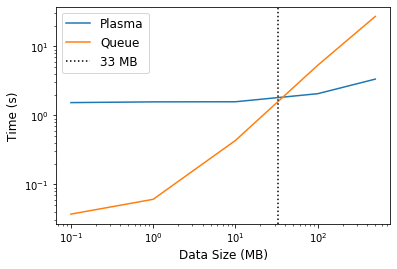

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

data_sizes = [0.1, 1, 10 ,100, 500] # units of MB
cross_over_point = 33 # eyeballed from graph 

plt.plot(data_sizes, plsm_run_times, label='Plasma')
plt.plot(data_sizes, q_run_times, label='Queue')
plt.axvline(cross_over_point, linestyle = ':', 
            color='k', label=f'{cross_over_point} MB')
plt.legend(fontsize=12)
plt.xlabel('Data Size (MB)', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.yscale('log')
plt.xscale('log')

As we can see Pyarrow Plasma has a relatively constant time curve as we increase data scale. Plasma allows Python processes to share data by sharing memory addresses rather than passing the data through serialization like Multiprocessing.Queue. On my system we see Plasma out-performs Multiprocessing.Queue at about 33MB data chunk sizes. 

## Splitting Pipeline

Now lets look at a different type of topology, where the pipeline splits into multiple downstreams. 

In [72]:
from minipipe import Stream

@Transform
def split(data):
    return data, data, data

def build_pipeline(data, plasma):
    # Define streams inside build function
    # So they're re-initiated at each build
    snk_strm = Stream(plasma=plasma) # Streams are Multiprocessing.Queue by default
    splt_strms = [Stream(plasma=plasma) for _ in range(3)]
    
    pline = (Pipeline(plasma=plasma, 
                      log_lvl='ERROR',  # supress outptus 
                      plasma_memory=30) # memory allocated for plasma store
             .add(gen_data(data, n=10))
             .add(split, downstream=splt_strms)
             .add(trans, upstream=splt_strms[0], downstream=snk_strm)
             .add(trans, upstream=splt_strms[1], downstream=snk_strm)
             .add(trans, upstream=splt_strms[2], downstream=snk_strm)
             .add(print_data, upstream=snk_strm)
             .build())
    
    return pline

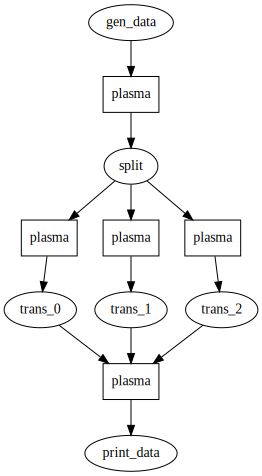

In [73]:
build_pipeline(data, True).diagram(True)

In [74]:
plsm_run_times = time_pipeline(plasma=True)
q_run_times = time_pipeline(plasma=False)

Again we'll graph the results to find the cross-over point. 

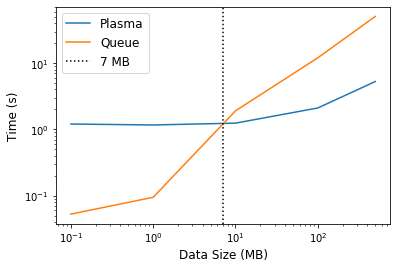

In [76]:
data_sizes = [0.1, 1, 10 ,100, 500] # units of MB
cross_over_point = 7 # eyeballed from graph 

plt.plot(data_sizes, plsm_run_times, label='Plasma')
plt.plot(data_sizes, q_run_times, label='Queue')
plt.axvline(cross_over_point, linestyle = ':', 
            color='k', label=f'{cross_over_point} MB')
plt.legend(fontsize=12)
plt.xlabel('Data Size (MB)', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.yscale('log')
plt.xscale('log')

This time we see that the cross-over happens at only 7MB! Indeed the type of Stream that is most efficient will depend on they topology of the pipeline. In this case Plasma is much faster because of the split operation. The Queue Stream has to copy the data three times before passing it to the downstream. On the other hand, the Plasma Stream simply sends the address downstream avoiding the costly copy operation. 